Today I will attempt to **predict whether or not an individual will suffer a stroke.**

First, I will perform extensive data visualization. This will help me to see if there are any features that look to be indicative of a stroke, or indeed of not having a stroke.

Next, I will build multiple models and select the best performing one. I will use f1 score as my primary metric as our dataset is imbalanced (though I will also resolve this with SMOTE).

**I will also delve in to Model Interpretation**
This is incfedibly important in industry. Often we need to explain very technical algorithms to a non-technical audience, so any tool that can help this process should be mastered.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from imblearn.over_sampling import SMOTE
import scikitplot as skplt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.drop(columns = ['id'],inplace = True)
data=df.copy()
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.shape

(5110, 11)

In [4]:
data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


# Missing Data

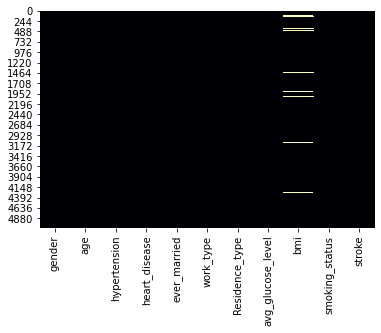

In [6]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

In [7]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [8]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

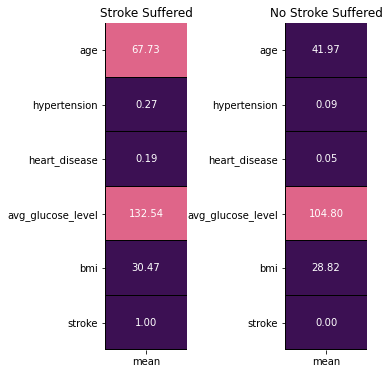

In [9]:
stroke = data[data['stroke'] == 1].describe().T
no_stroke = data[data['stroke'] == 0].describe().T

colors = ['#3C1053','#DF6589']

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(stroke[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Stroke Suffered');

plt.subplot(1,2,2)
sns.heatmap(no_stroke[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('No Stroke Suffered');

fig.tight_layout(pad = 0)

- Mean values of all the features for cases of stroke suffered and no stroke suffered.
- age and avg_glucose_level can be solid 1st hand indicators to identify a stroke.
- Mean age values of patients that suffered a stroke, 67.73,is much higher than those did not suffer a stroke, 41.97.
- Similarly, avg_glucose_level value of 132.54 can indicate a higher chance of suffering from stroke than the avg_glucose_level value of 104.80 that has been found in patients that did not suffer a stroke.

**How can we deal with blanks in our data?**

There are many ways. One can simply drop these records, fill the blanks with the mean, the median, or even simply the record before or after the missing value.

But there are other, more unusual ways. 

Here I will use 
# ** Machine learning to predict the missing Value

Other interesting methods to explore could include using K-Nearest-Neighbours to fill the gaps.

In [10]:
# A really fantsatic and intelligent way to deal with blanks, from Thoman Konstantin in: https://www.kaggle.com/thomaskonstantin/analyzing-and-modeling-stroke-data

DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [11]:
print('Missing values: ',sum(df.isnull().sum()))

Missing values:  0


# Use mean/ Median to Fill Missing Value

From the table of descriptive statistics, we observe that mean and median values of bmi are very close to each other.
Hence, we will fill the missing values with the mean values.

In [12]:
from tqdm import tqdm

l1 = [i for i in tqdm(range(len(data.isnull()['bmi']))) if data.isnull().loc[i,'bmi'] == True]
print('Total Number of Missing Values in bmi feature :', len(l1))

100%|██████████| 5110/5110 [00:05<00:00, 862.52it/s]

Total Number of Missing Values in bmi feature : 201


In [13]:
data['bmi'].fillna(data['bmi'].mean(),inplace = True)

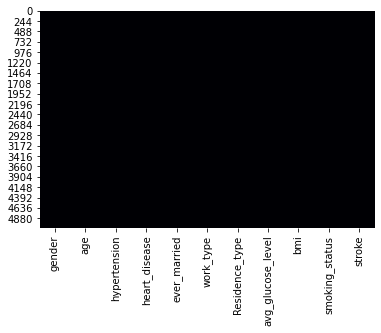

In [14]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

# Exploring the data

In [15]:
col = list(data.columns)
categorical_features = []
discrete_features = []
for i in col:
    if len(data[i].unique()) > 6:
        discrete_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Discrete Features :',*discrete_features)

data['age'] = data['age'].astype(int)
df1 = data.copy(deep = True)

Categorical Features : gender hypertension heart_disease ever_married work_type Residence_type smoking_status stroke
Discrete Features : age avg_glucose_level bmi


Here, categorical features are defined if the the attribute has less than 6 unique elements else it is a discrete feature.

Typical approach for this division of features can also be based on the datatypes of the elements of the respective attribute.

Eg : datatype = integer, attribute = discrete feature ; datatype = string, attribute = categorical feature

Creating a deep copy of the orginal dataset for experimenting with data, visualization and modeling.

Modifications in the original dataset will not be highlighted in this deep copy.
We now Label Encode the data categorical text data features.

In [16]:
le = LabelEncoder()
text_data_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    df1[i] = le.fit_transform(df1[i])
    l3.append(list(df1[i].unique())); l4.append(list(le.inverse_transform(df1[i].unique())))
    print(i,' : ',df1[i].unique(),' = ',le.inverse_transform(df1[i].unique()))

100%|██████████| 5/5 [00:00<00:00, 256.29it/s]

Label Encoder Transformation
gender  :  [1 0 2]  =  ['Male' 'Female' 'Other']
ever_married  :  [1 0]  =  ['Yes' 'No']
work_type  :  [2 3 0 4 1]  =  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type  :  [1 0]  =  ['Urban' 'Rural']
smoking_status  :  [1 2 3 0]  =  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


- We store the label encoded transformations inside a dictionary that gives us the information about the encoded value and it's original value!
- We add the remaining 2 features manually i.e heart_disease & hypertension!

In [17]:
tf1 = {}
for i in range(len(text_data_features)):
    tf1[text_data_features[i]] = {}
    for j,k in zip(l3[i],l4[i]):
        tf1[text_data_features[i]][j] = k

tf1['hypertension'] = {0 : 'No Hypertension', 1 : 'Hypertension'} 
tf1['heart_disease'] = {0 : 'No Heart Disease', 1 : 'Heart Disease'}
tf1

{'gender': {1: 'Male', 0: 'Female', 2: 'Other'},
 'ever_married': {1: 'Yes', 0: 'No'},
 'work_type': {2: 'Private',
  3: 'Self-employed',
  0: 'Govt_job',
  4: 'children',
  1: 'Never_worked'},
 'Residence_type': {1: 'Urban', 0: 'Rural'},
 'smoking_status': {1: 'formerly smoked',
  2: 'never smoked',
  3: 'smokes',
  0: 'Unknown'},
 'hypertension': {0: 'No Hypertension', 1: 'Hypertension'},
 'heart_disease': {0: 'No Heart Disease', 1: 'Heart Disease'}}

# Target Variable Visualization (stroke)

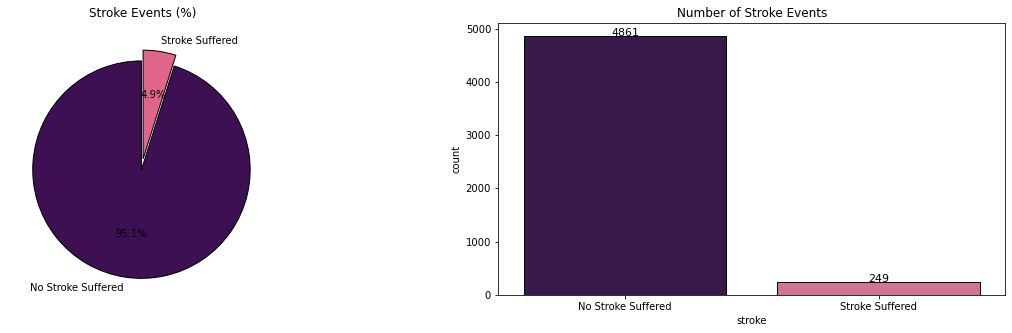

In [18]:
l = list(df1['stroke'].value_counts())
circle = [l[0] / sum(l) * 100,l[1] / sum(l) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))
plt.subplot(1,2,1)
plt.pie(circle,labels = ['No Stroke Suffered','Stroke Suffered'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Stroke Events (%)');

plt.subplot(1,2,2)
ax = sns.countplot('stroke',data = df1, palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
ax.set_xticklabels(['No Stroke Suffered','Stroke Suffered'])
plt.title('Number of Stroke Events');
plt.show()

# Discrete Features

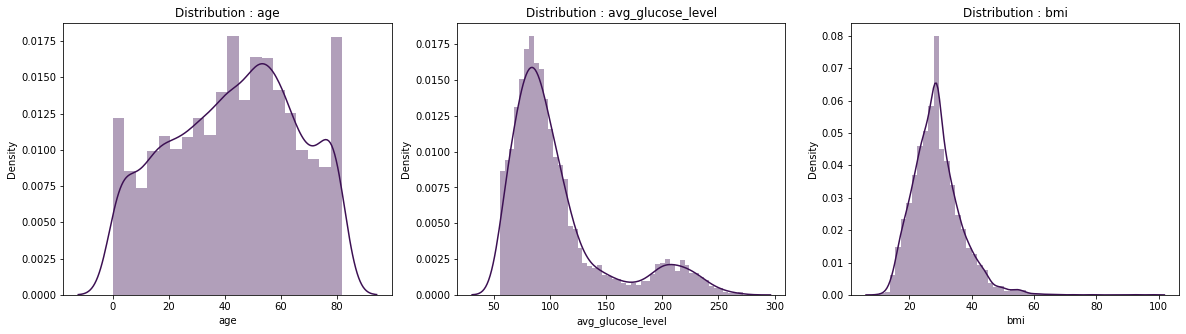

In [19]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (20,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    sns.distplot(df1[discrete_features[i]],color = colors[0])
    title = 'Distribution : ' + discrete_features[i]
    plt.title(title)
plt.show()

- Data distribution for age has dominant values around : 10, 60 & 80.
- avg_glucose_level has 2 peaks of uneven heights present at values around : 100 & 200.
- bmi has a near about normal distribution but it has values in low numbers towards the right side!

# Discrete Features vsTarget Variable (stroke)

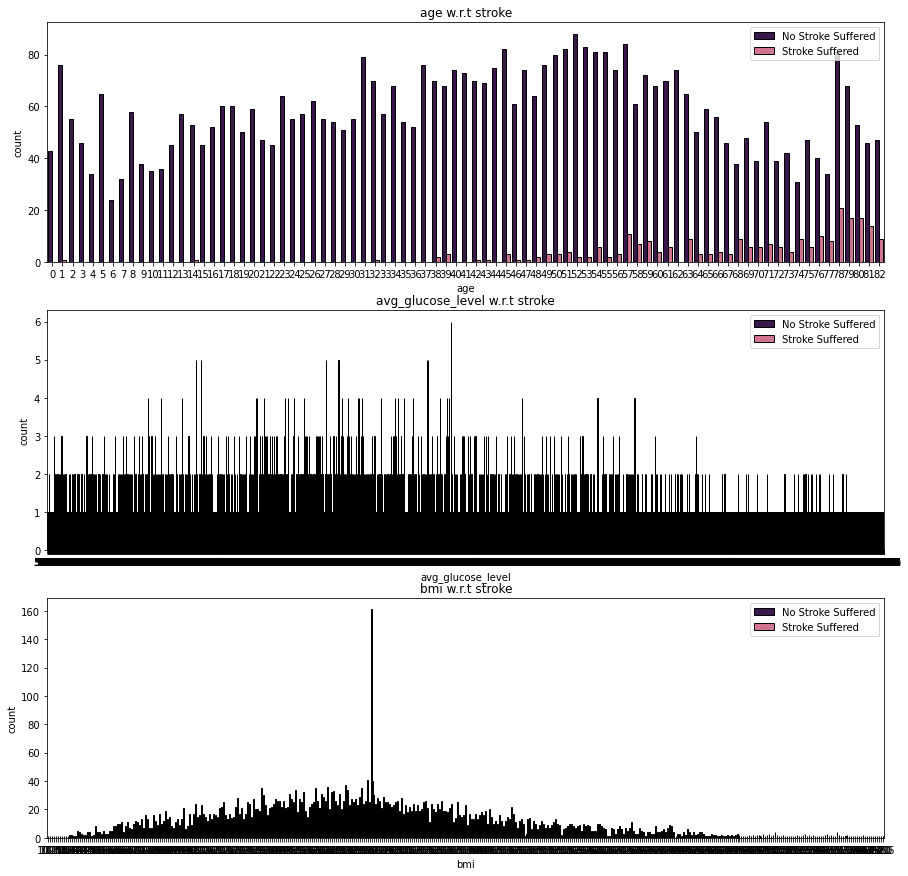

In [20]:
fig, ax = plt.subplots(nrows = 3,ncols = 1,figsize = (15,15))
for i in range(len(discrete_features)):
    plt.subplot(3,1,i+1)
    sns.countplot(discrete_features[i],data = df1,hue = "stroke",palette = colors,edgecolor = 'black')
    plt.legend(['No Stroke Suffered', 'Stroke Suffered'] ,loc = 'upper right')
    title = discrete_features[i] + ' w.r.t stroke'
    plt.title(title);

- Because of too many unique data points in the discrete_features, it is difficult to gain any type of insight. Thus, we will convert these features into categorical features for visualizations.
- We scale the data points of these features to a constant value that represents a range of values.(like mean)
- Here, we divide the data points by a constant value and assign it's quotient value as the representative constant. The scaling constants are decided by looking into the data & intuition.

In [21]:
df1['age_group'] = [ int(i / 5) for i in df1['age']]
df1['avg_glucose_level_group'] = [ int(i / 20) for i in df1['avg_glucose_level']]
df1['bmi_group'] = [ int(i / 5) for i in df1['bmi']]

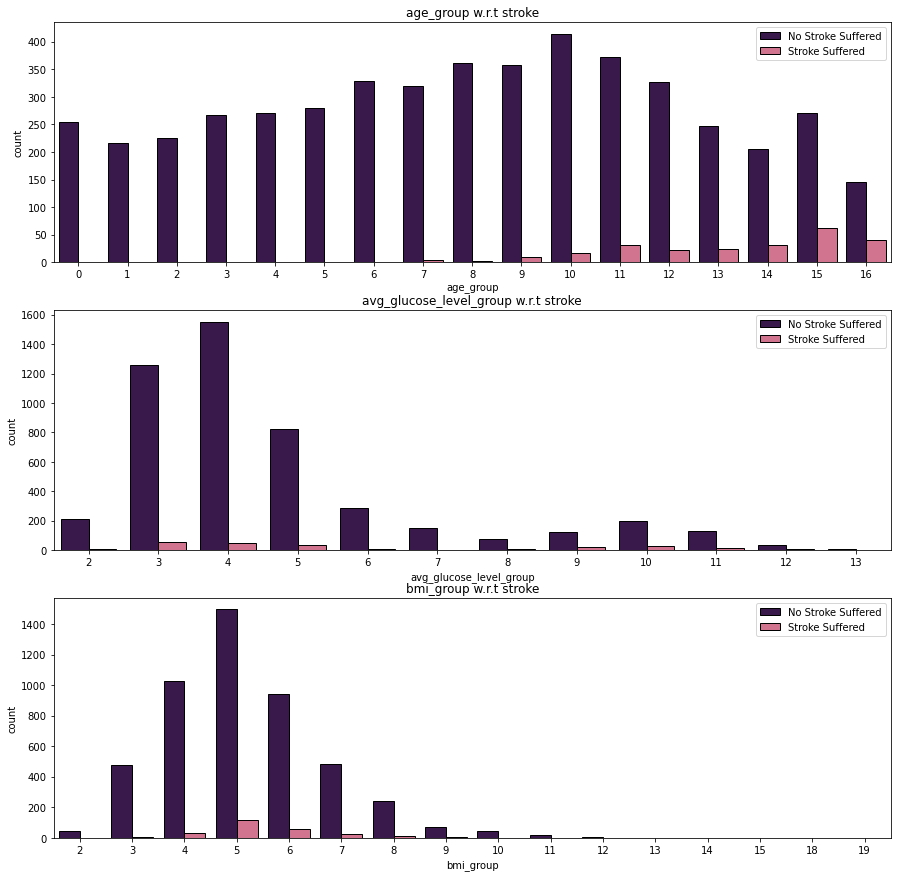

In [22]:
fig, ax = plt.subplots(nrows = 3,ncols = 1,figsize = (15,15))
group_numerical_features = [i + '_group' for i in ['age','avg_glucose_level','bmi']]

for i in range(len(group_numerical_features)):
    plt.subplot(3,1,i+1)
    sns.countplot(group_numerical_features[i],data = df1,hue = "stroke",palette = colors,edgecolor = 'black')
    plt.legend(['No Stroke Suffered', 'Stroke Suffered'] ,loc = 'upper right')
    title = group_numerical_features[i] + ' w.r.t stroke'
    plt.title(title);

- For age, cases of stroke suffered can be observed for the values between 35(7x5) - 80(16x5). It is not a dominant patch due to the imbalance nature of the dataset.
- For avg_glucose_level, 2 groups can be found : 60(3x20) - 100(5x20) & 180(9x20) - 220(11x20). Patients with avg_glucose_level present in the 1st group are more prone to suffering stroke than group 2.
- bmi values from 15(3x5) - 40(8x5) have displayed more cases of stroke.

# Categorical Features

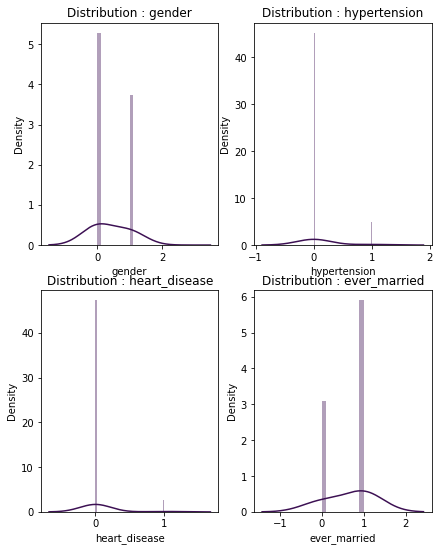

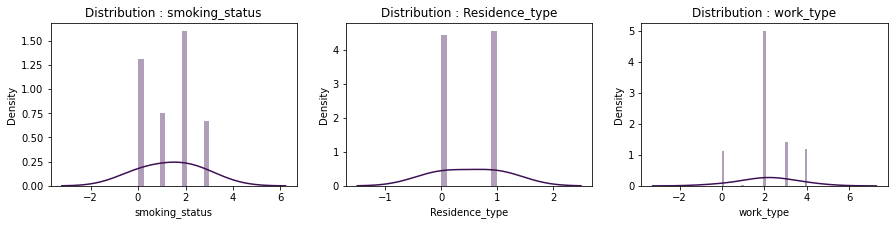

In [23]:
categorical_features.remove('stroke')

fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize = (7,9))
for i in range(len(categorical_features[:4])):
    plt.subplot(2,2,i+1)
    sns.distplot(df1[categorical_features[i]],kde_kws = {'bw' : 1},color = colors[0]);
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)
    
fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,3))
for i in range(-1,-4,-1):
    plt.subplot(1,3,-i)
    sns.distplot(df1[categorical_features[i]],kde_kws = {'bw' : 1},color = colors[0]);
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)

All the categorical features are Normally Distributed.

# Categorical Features vs Target Variable (stroke) 

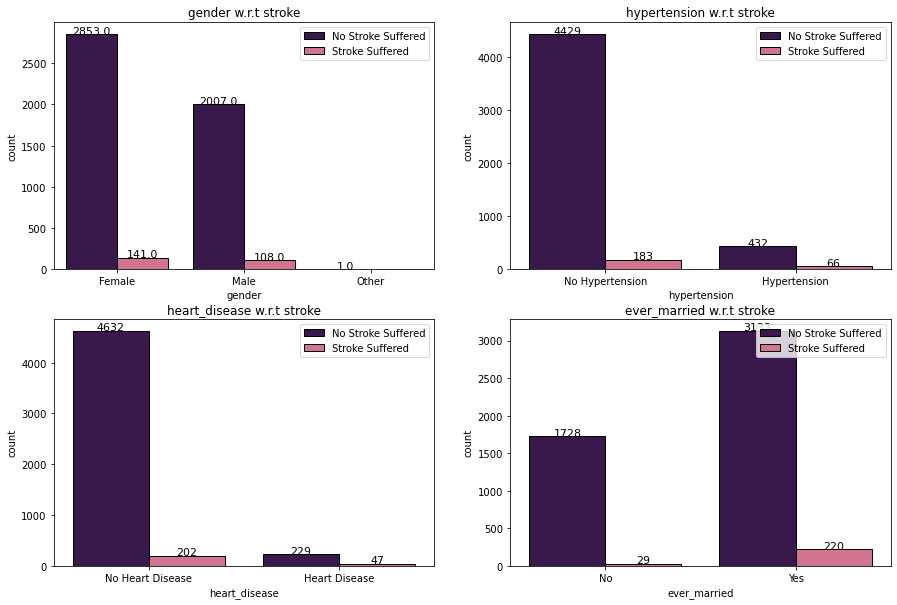

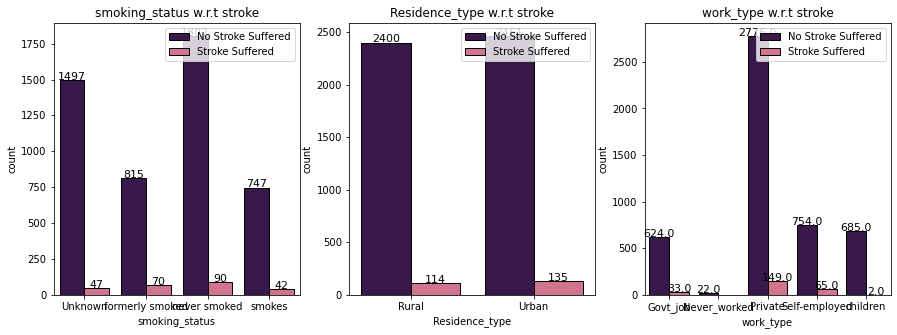

In [24]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(categorical_features[i],data = df1,hue = "stroke",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    ax.set_xticklabels([tf1[categorical_features[i]][j] for j in sorted(df1[categorical_features[i]].unique())])
    plt.legend(['No Stroke Suffered', 'Stroke Suffered'], loc = 'upper right')
    title = categorical_features[i] + ' w.r.t stroke'
    plt.title(title);

fig = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(-1,-4,-1):
    plt.subplot(1,3,-i)
    ax = sns.countplot(categorical_features[i],data = df1,hue = "stroke",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    ax.set_xticklabels([tf1[categorical_features[i]][j] for j in sorted(df1[categorical_features[i]].unique())])
    plt.legend(['No Stroke Suffered', 'Stroke Suffered'], loc = 'upper right')
    title = categorical_features[i] + ' w.r.t stroke'
    plt.title(title);

- All the graphs near about share the same pattern i.e displaying low number of stroke cases and no clear cut reason to point towards.
- Female population has recorded more cases of stroke than male.
- Interestingly, people with no hypertension & no heart disease have displayed to be more prone to suffering stroke than people that have these medical conditions.
- According to the dataset, people that have been married have suffered stroke more than those people who have never married.
- When it comes to smoking_status, people that have never smoked have topped the numbers with formerly smoked people coming at the 2nd position to record stroke cases.
- Not much info can be gained from Residence_type & work_type, however Private workers suffered stroke cases more than any other worker.

# Categorical Features w.r.t Positive Cases of stroke

In [25]:
gender = df1[df1['stroke'] == 1]['gender'].value_counts()
gender = [gender[0] / sum(gender) * 100, gender[1] / sum(gender) * 100]

hypertension = df1[df1['stroke'] == 1]['hypertension'].value_counts()
hypertension = [hypertension[0] / sum(hypertension) * 100, hypertension[1] / sum(hypertension) * 100]

heart_disease = df1[df1['stroke'] == 1]['heart_disease'].value_counts()
heart_disease = [heart_disease[0] / sum(heart_disease) * 100, heart_disease[1] / sum(heart_disease) * 100]

ever_married = df1[df1['stroke'] == 1]['ever_married'].value_counts()
ever_married = [ever_married[0] / sum(ever_married) * 100, ever_married[1] / sum(ever_married) * 100]

work_type = df1[df1['stroke'] == 1]['work_type'].value_counts()
work_type = [work_type[0] / sum(work_type) * 100, work_type[2] / sum(work_type) * 100,
             work_type[3] / sum(work_type) * 100, work_type[4] / sum(work_type) * 100,]

Residence_type = df1[df1['stroke'] == 1]['Residence_type'].value_counts()
Residence_type = [Residence_type[0] / sum(Residence_type) * 100, Residence_type[1] / sum(Residence_type) * 100]

smoking_status = df1[df1['stroke'] == 1]['smoking_status'].value_counts()
smoking_status = [smoking_status[0] / sum(smoking_status) * 100, smoking_status[1] / sum(smoking_status) * 100,
                  smoking_status[2] / sum(smoking_status) * 100, smoking_status[3] / sum(smoking_status) * 100]

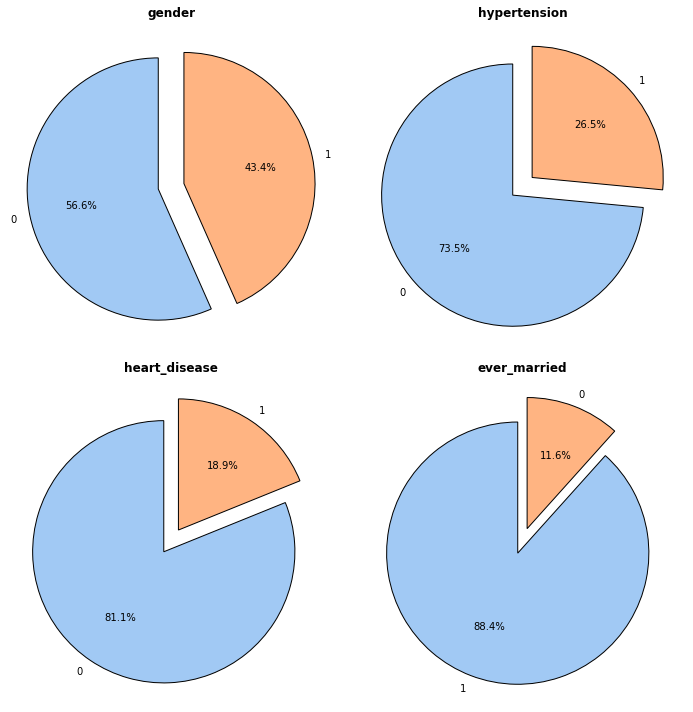

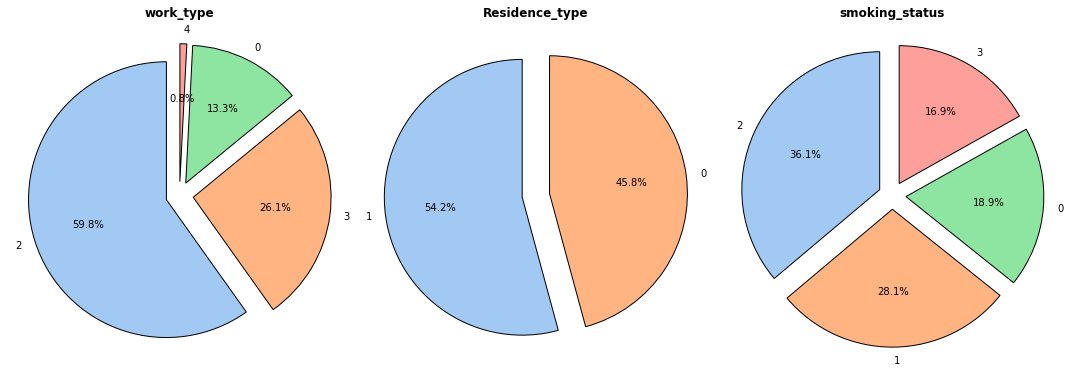

In [26]:
# Prepare list of categorical feature names
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                        'work_type', 'Residence_type', 'smoking_status']

# Compute frequency counts for stroke = 1
l1 = [df1[df1['stroke'] == 1][col].value_counts() for col in categorical_features]

colors = sns.color_palette("pastel")

# --- FIRST FIGURE ---
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.patch.set_facecolor('white')

for i in range(4):
    data = l1[i]
    plt.subplot(2, 2, i + 1)
    explode = (0.1,) * len(data)
    plt.pie(
        data.values,
        labels=data.index,
        autopct='%1.1f%%',
        startangle=90,
        explode=explode,
        colors=colors[:len(data)],
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True}
    )
    plt.title(categorical_features[i], fontweight='bold')

plt.tight_layout()
plt.show()

# --- SECOND FIGURE ---
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
fig.patch.set_facecolor('white')

for idx, i in enumerate(range(4, 7)):
    data = l1[i]
    plt.subplot(1, 3, idx + 1)
    explode = (0.1,) * len(data)
    plt.pie(
        data.values,
        labels=data.index,
        autopct='%1.1f%%',
        startangle=90,
        explode=explode,
        colors=colors[:len(data)],
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True}
    )
    plt.title(categorical_features[i], fontweight='bold')

plt.tight_layout()
plt.show()


- According to the data, female population is more susceptible to suffering stroke.
- From the above visuals, surprisingly, stroke cases were found more in patients that did not have any medical conditions like heart_disease or hypertension!
- People that have been married have the highest probability of suffering from stroke.
- When it comes to stroke & smoking_status, people that have never smoked are most susceptible. They are followed by formerly smoked. Surprisingly, people that smokes have the lowest chances of suffering from stroke.
- People living in Urban Residence Type have edged the people living in Rural Residence Type in terms of stroke cases.
- When it comes to work_type, people working in Private have recorded more than 50%+ of stroke cases. It is followed by Self-employed & Govt_job that record half and quarter of the cases that Private recorderd respectively.

# Categorical features vs Discrete features w.r.t Target variable (stroke) : 

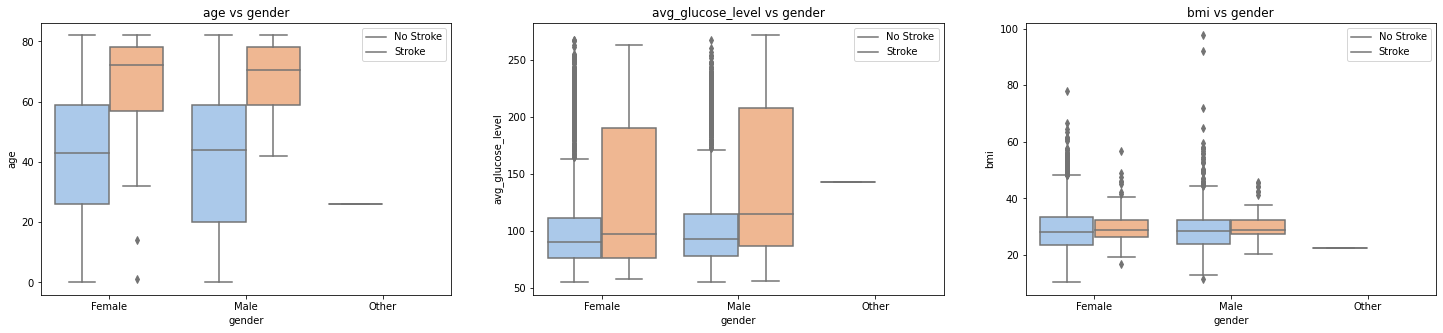

In [27]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    ax = sns.boxplot(x = 'gender',y = discrete_features[i],data = df1,hue = 'stroke',palette = colors);
    ax.set_xticklabels([tf1['gender'][j] for j in sorted(df1['gender'].unique())])
    title = discrete_features[i] + ' vs gender'
    plt.legend(['No Stroke','Stroke'], loc = 'upper right')
    plt.title(title);

- For both male & female population, age of those suffering from stroke is 60+.
- For majority of the avg_glucose_level values, both gender have recorded significant cases of stroke.
- For male population, the lower limit of bmi values is slightly higher than the female.
-  Overall, both the gender overlap the same bmi values for cases of stroke.

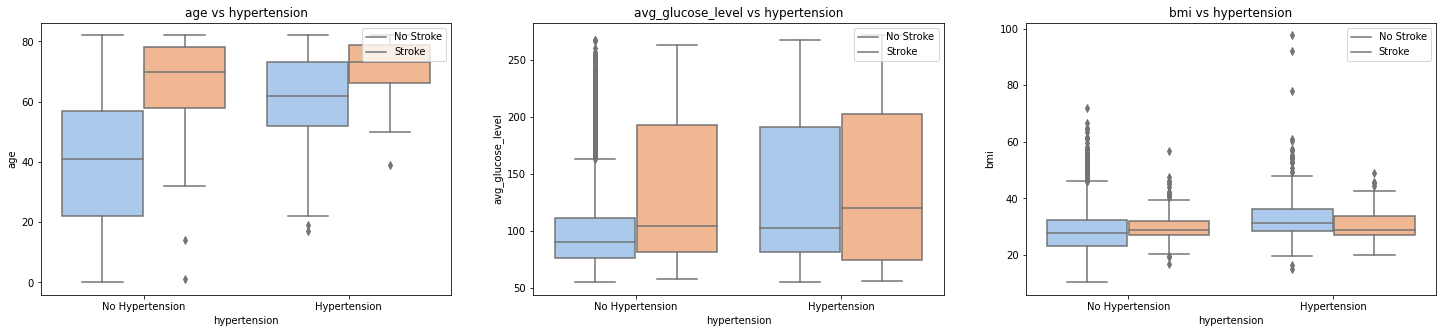

In [28]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    ax = sns.boxplot(x = 'hypertension',y = discrete_features[i],data = df1,hue = 'stroke',palette = colors);
    ax.set_xticklabels([tf1['hypertension'][j] for j in sorted(df1['hypertension'].unique())])
    title = discrete_features[i] + ' vs hypertension'
    plt.legend(['No Stroke','Stroke'], loc = 'upper right')
    plt.title(title);

- Wierdly, cases of stroke found in people having hypertension have a high lower limit of the age 60+ than those who do not suffer from hypertension.
- When it comes to hypertension & avg_glucose_level, cases of stroke & no stroke near about share the same values.
- Due to hypertension, lower limits of bmi values are slightly reduced making people prone to stroke.

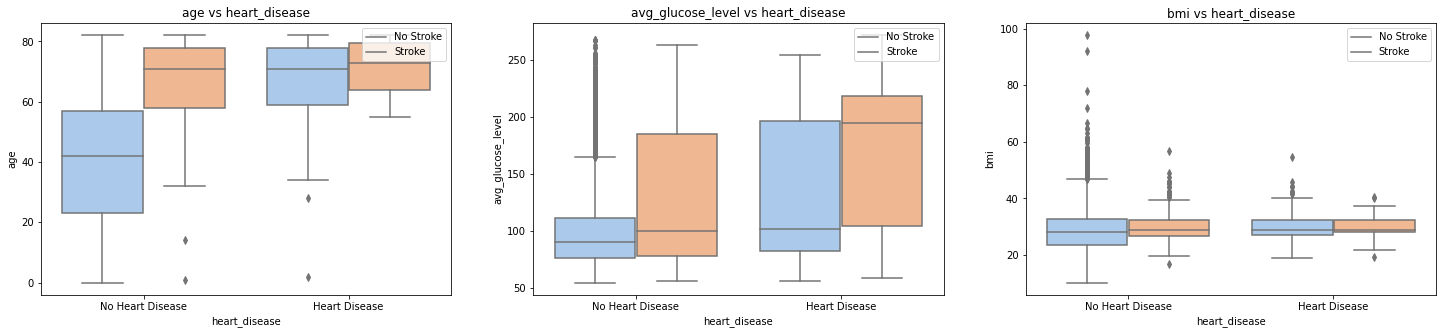

In [29]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    ax = sns.boxplot(x = 'heart_disease',y = discrete_features[i],data = df1,hue = 'stroke',palette = colors);
    ax.set_xticklabels([tf1['heart_disease'][j] for j in sorted(df1['heart_disease'].unique())])
    title = discrete_features[i] + ' vs heart_disease'
    plt.legend(['No Stroke','Stroke'], loc = 'upper right')
    plt.title(title);

- Graphs of hypertension & heart_disease against discrete features are very similar with slight differences.
- They share the same effects on stroke.

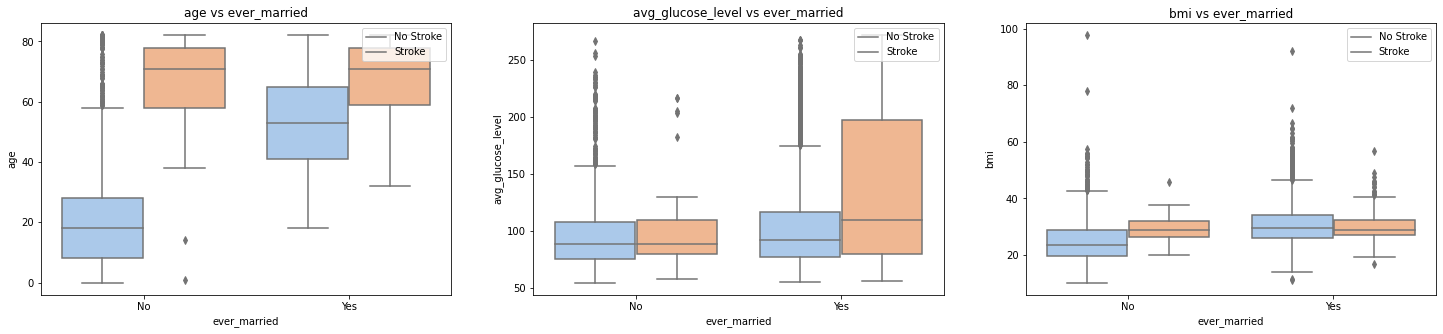

In [30]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    ax = sns.boxplot(x = 'ever_married',y = discrete_features[i],data = df1,hue = 'stroke',palette = colors);
    ax.set_xticklabels([tf1['ever_married'][j] for j in sorted(df1['ever_married'].unique())])
    title = discrete_features[i] + ' vs ever_married'
    plt.legend(['No Stroke','Stroke'], loc = 'upper right')
    plt.title(title);

- For ever_married vs discrete features, repeated insights can be found.
- People that have been married have displayed cases of stroke for near about all the values of avg_glucose_level.

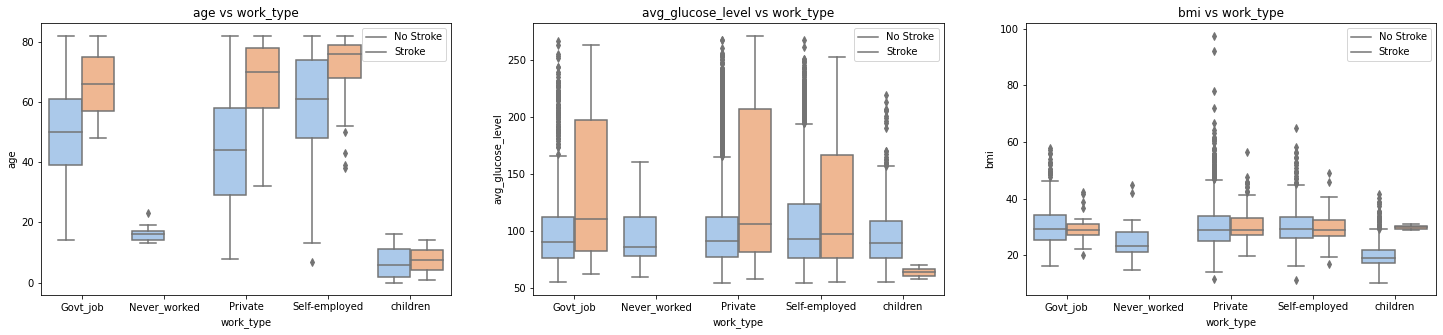

In [31]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    ax = sns.boxplot(x = 'work_type',y = discrete_features[i],data = df1,hue = 'stroke',palette = colors);
    ax.set_xticklabels([tf1['work_type'][j] for j in sorted(df1['work_type'].unique())])
    title = discrete_features[i] + ' vs work_type'
    plt.legend(['No Stroke','Stroke'], loc = 'upper right')
    plt.title(title);

- Irrespective of the work_type, stroke cases have been found for age of 60+ except for children.
- Clearly, people that have worked to earn a living have suffered from stroke.
- Stroke cases have been found more in people working in a job i.e Govt_job & Private than those who are Self-employed.

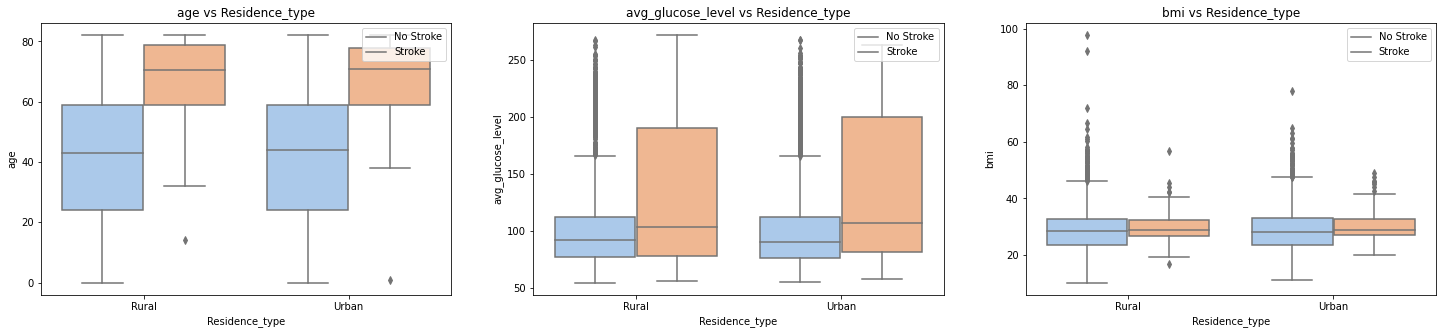

In [32]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    ax = sns.boxplot(x = 'Residence_type',y = discrete_features[i],data = df1,hue = 'stroke',palette = colors);
    ax.set_xticklabels([tf1['Residence_type'][j] for j in sorted(df1['Residence_type'].unique())])
    title = discrete_features[i] + ' vs Residence_type'
    plt.legend(['No Stroke','Stroke'], loc = 'upper right')
    plt.title(title);

- The graphs of Rural Residence_type & Urban Residence_type against discrete features w.r.t stroke are identical.
- They cannot be separated from each other.
- They repeat the insights that have been highlighted uptill now.

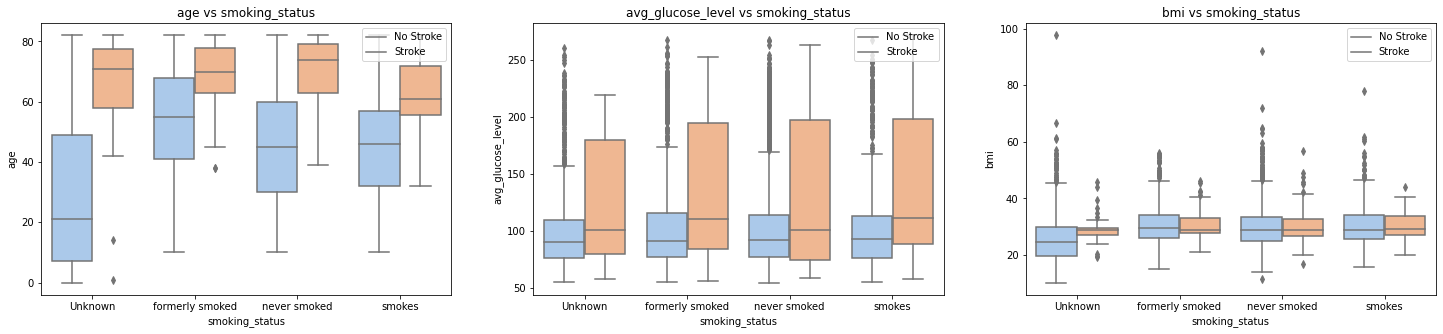

In [33]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    ax = sns.boxplot(x = 'smoking_status',y = discrete_features[i],data = df1,hue = 'stroke',palette = colors);
    ax.set_xticklabels([tf1['smoking_status'][j] for j in sorted(df1['smoking_status'].unique())])
    title = discrete_features[i] + ' vs smoking_status'
    plt.legend(['No Stroke','Stroke'], loc = 'upper right')
    plt.title(title);

- Irrespective of smoking_status, people suffering from stroke have been detected at age around 60.
- Similar to age, same values of avg_glucose_level have been found in stroke cases irrespective of smoking_status.
- However, because of the smoking_status, range of values for which cases of stroke differ. Range of values of people that smokes is slightly higher than everyone else.

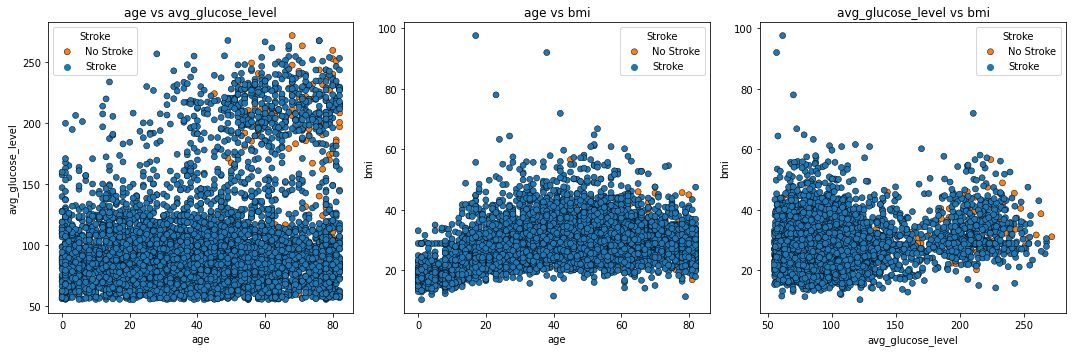

In [34]:
colors = ['#1f77b4', '#ff7f0e']  # for hue=stroke classes

pairs = []
for i in range(len(discrete_features) - 1):
    for j in range(i + 1, len(discrete_features)):
        pairs.append((discrete_features[i], discrete_features[j]))

fig, axes = plt.subplots(1, len(pairs), figsize=(5 * len(pairs), 5))

if len(pairs) == 1:
    axes = [axes]

for ax, (x_feat, y_feat) in zip(axes, pairs):
    sns.scatterplot(
        x=x_feat,
        y=y_feat,
        data=df1,
        hue='stroke',
        palette=colors,
        edgecolor='black',
        ax=ax
    )
    ax.set_title(f"{x_feat} vs {y_feat}")
    ax.legend(title='Stroke', labels=['No Stroke', 'Stroke'])

plt.tight_layout()
plt.show()

- Due to the imbalance nature of the data, cases of stroke & no stroke cannot be separated.
- No insights can be interpreted from the above graphs.

# Summary of EDA
Order / Values of features for positive cases of stroke :

**Categorical Features (Order)** :

gender : female > male

hypertension : no hypertension > hypertension

heart_disease : no heart disease > heart disease

ever_married : married > no married

working_type : Private > Self-employed > Govt_job > children

Residence_type : Urban > Rural

smoking_status : never smoked > formerly smoked > smokes

**Discrete Features (Range)** :

age : 55 - 80
avg_glucose_level : 80 - 200
bmi : 20 - 40
According to the data, these order / range of values leads to heart failures.

# Domain Information

Categorical Features (Order) :

gender : male > female

hypertension : hypertension > no hypertension

heart_disease : heart disease > no heart disease

ever_married : married = not married

working_type : Stress of the work can lead to stroke.

Residence_type : Mortality due to stroke is higher in rural areas than urban areas due to poor medical treatment.

smoking_status : Smoking increases the risk of stroke.

Discrete Features (Range) :

age : The chance of having a stroke about doubles every 10 years after age 55.

avg_glucose_level : High blood glucose is found in stroke cases. A value of 126+ has been observed alot.

bmi : High bmi values increases the chances of ischemic stroke.

- All the information mentioned is gathered from websites and research papers. We will use this information for cross checking the summary of EDA and feature selection.
- Conclusions obtained from the EDA contradict the Domain Information for the features : hypertension, heart_disease and smoking_status.
- This difference is probably because of the Unbalanced dataset!
- Thus, we will carry out the feature engineering process, balance the dataset using SMOTE analysis and feed the balanced to the ML algorithms.

In [35]:
gc.collect()
time.sleep(5)

# Preparing  The Dataset

In [36]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [37]:
df1

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,avg_glucose_level_group,bmi_group
0,1,67,0,1,1,2,1,228.69,36.600000,1,1,13,11,7
1,0,61,0,0,1,3,0,202.21,28.893237,2,1,12,10,5
2,1,80,0,1,1,2,0,105.92,32.500000,2,1,16,5,6
3,0,49,0,0,1,2,1,171.23,34.400000,3,1,9,8,6
4,0,79,1,0,1,3,0,174.12,24.000000,2,1,15,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80,1,0,1,2,1,83.75,28.893237,2,0,16,4,5
5106,0,81,0,0,1,3,1,125.20,40.000000,2,0,16,6,8
5107,0,35,0,0,1,3,0,82.99,30.600000,2,0,7,4,6
5108,1,51,0,0,1,2,0,166.29,25.600000,1,0,10,8,5


In [38]:
over = SMOTE(sampling_strategy = 1)
under = RandomUnderSampler(sampling_strategy = 0.1)
f1 = df1.loc[:,:'smoking_status']
t1 = df1.loc[:,'stroke']

steps = [('under', under),('over', over)]
pipeline = Pipeline(steps=steps)
f1, t1 = pipeline.fit_resample(f1, t1)
Counter(t1)

Counter({0: 2490, 1: 2490})

# Calculation for Data Balancing 
Sampling Strategy : It is a ratio which is the common paramter for oversampling and undersampling.

Sampling Strategy : ( Samples of Minority Class ) / ( Samples of Majority Class )
In this case,

Majority Class : No Stroke : 4861 samples

Minority Class : Stroke : 249 samples

Undersampling : Trim down the majority class samples

Sampling_Strategy = 0.1

0.1 = ( 249 ) / Majority Class Samples

After undersampling,

Majority Class : No Stroke : 2490 samples

Minority Class : Stroke : 249 samples

Oversampling : Increase the minority class samples

Sampling_Strategy = 1

1 = ( Minority Class Samples ) / 2490

After oversampling,

Majority Class : No Stroke : 2490 samples

Minority Class : Stroke : 2490 samples

Final Class Samples :

Majority Class : No Stroke : 2490 samples

Minority Class : Stroke : 2490 samples

Here, we balance the data by reducing the majority group samples & then increasing the minority group to majority group.

For imbalanced datasets, we duplicate the data to deal with the potential bias in the predictions.

Due to this duplication process, we are using synthetic data for modeling purposes to ensure that the predictions are not skewed towards the majority target class value.

Thus, evaluating models using accuracy will be misleading. Instead, we will go for confusion matrix, ROC-AUC graph and ROC-AUC score for model evaluation

# Data Leakage 

Data Leakage is the problem when the information outside the training data is used for model creation. It is one of the most ignored problem.

In order to create robust models, solving data leakage is a must! Creation of overly optimistic models which are practically useless & cannot be used in production have become common.

Model performance degrades when Data Leakage is not dealt with & the model is sent online. It is a difficult concept to understand because it seems quite trivial.
Typical approach used is transforming / modifying the entire dataset by filling NAN values with mean, median & mode, standardisation, normalization, etc.

When we execute the above process in order to make the dataset ready for modeling, we use the values from the entire dataset & thus indirectly provide information from the to-be test data i.e outside of the training data.

Thus, in order to avoid Data Leakage, it is advised to use train-test-split before any transformations. Execute the transformations according to the training data for the training as well as test data. Use of k-fold cross validation is also suggested!
We will display the effect of Data Leakage from the following code snippet!

In [39]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(f1, t1, test_size = 0.15, random_state = 2)

In [40]:
x_train_test = x_train.copy(deep = True)
x_train_test['stroke'] = y_train

In order to visualize the correlation matrix, we create a new dataframe that contains values from x_train & y_train.

Thus, we reject anything outside the training data to avoid data leakage.

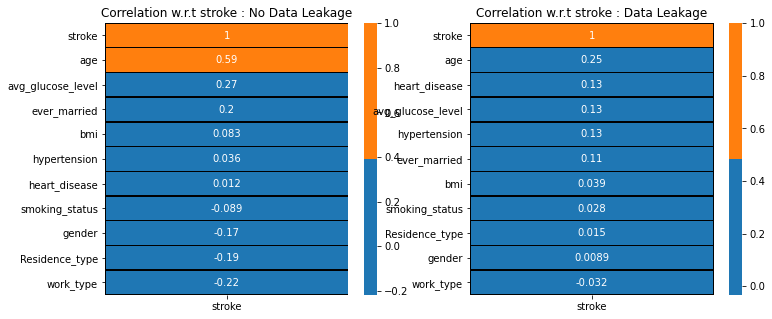

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

plt.subplot(1,2,1)
corr = x_train_test.corrwith(x_train_test['stroke']).sort_values(ascending = False).to_frame()
corr.columns = ['stroke']
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t stroke : No Data Leakage');

plt.subplot(1,2,2)
corr = df1.drop(columns = ['age_group', 'avg_glucose_level_group', 'bmi_group']).corrwith(df1['stroke']).sort_values(ascending = False).to_frame()
corr.columns = ['stroke']
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t stroke : Data Leakage');

Clearly, we can see the difference in values between Data Leakage & No Data Leakage.

In the case of No Data Leakage, age displays a strong positive correlation with stroke. avg_glucose_level & ever_married display some kind of positive correlation. Opposite to positive correlation, gender, Residence_type & work_type have negative correlation with the stroke.

In the case of Data Leakage, none of the features display an extreme positive or negative correlation with stroke.

age, heart_disease, avg_glucose_level, hypertension & ever_married display some kind of positive correlation. Overall, all the features have a value very close to 0, displaying neutral correlation with stroke.

# Feature Selection for Categorical Features

In [42]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif,chi2

## Mutual Information Test :

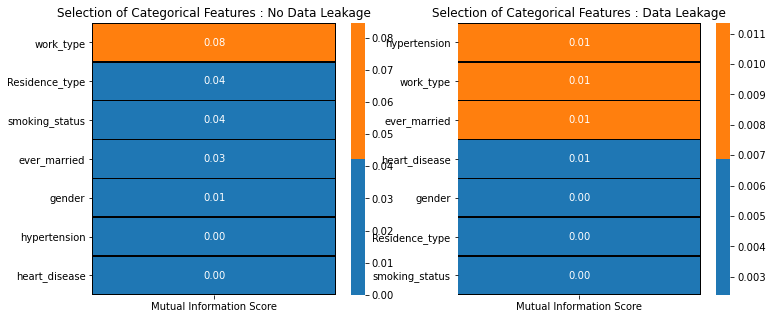

In [43]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

plt.subplot(1,2,1)
features = x_train.loc[:,categorical_features]
target = pd.DataFrame(y_train)

best_features = SelectKBest(score_func = mutual_info_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Mutual Information Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Mutual Information Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features : No Data Leakage');

plt.subplot(1,2,2)
features = df1.loc[:,categorical_features]
target = df1.loc[:,'stroke']

best_features = SelectKBest(score_func = mutual_info_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Mutual Information Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Mutual Information Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features : Data Leakage');

Mutual Information Score of stroke with categorical features display very low scores irrespective of Data Leakage or No Data Leakage.

According to the above scores, none of the features should be selected for modeling.

## Chi Squared Test

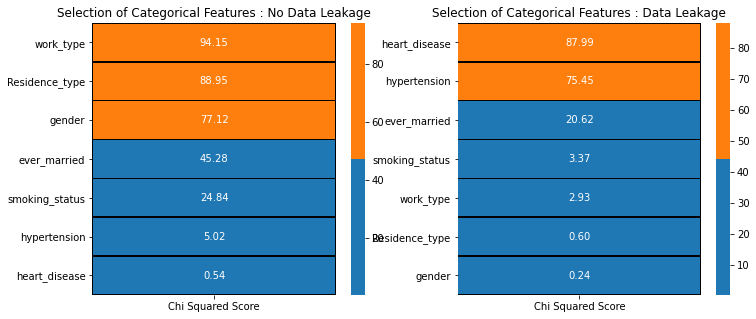

In [44]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

plt.subplot(1,2,1)
features = x_train.loc[:,categorical_features]
target = y_train

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features : No Data Leakage');

plt.subplot(1,2,2)
features = df1.loc[:,categorical_features]
target = df1.loc[:,'stroke']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features : Data Leakage');

For No Data Leakage, we should reject the features that have low values. We will reject features with scores less than 20. Hence, we will not use : smoking_status, heart_disease & hypertension. This does contradict with the Domain Information.

For Data Leakage, heart disease & hypertension need to be selected for modeling and reject the other features due to low Chi Squared Score.

# Feature Selection for Numerical Features
## ANOVA Test

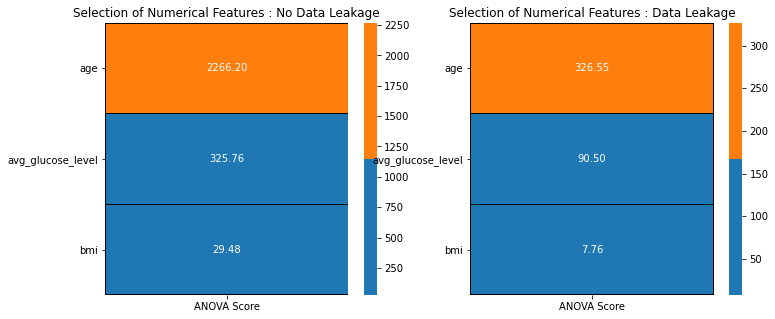

In [45]:
from sklearn.feature_selection import f_classif

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

plt.subplot(1,2,1)
features = x_train.loc[:,discrete_features]
target = y_train

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features : No Data Leakage');

plt.subplot(1,2,2)
features = df1.loc[:,discrete_features]
target = df1.loc[:, 'stroke']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features : Data Leakage');

From the above ANOVA Scores, we ignore the features with values less than 20. Hence, we reject bmi for modeling irrespective of Data Leakage or No Data Leakage.

We ready the datasets for data scaling by dropping the features based on the above statistical tests.

We will ignore the Domain Information!

In [46]:
# Feature Selection for No Data Leakage :
x_train = x_train.drop(columns = ['smoking_status', 'heart_disease', 'hypertension', 'bmi'])
x_test = x_test.drop(columns = ['smoking_status', 'heart_disease', 'hypertension', 'bmi'])

# Feature Selection for Data Leakage :
df2 = df1.drop(columns = ['smoking_status', 'work_type', 'Residence_type', 'gender', 
                          'bmi', 'age_group', 'avg_glucose_level_group', 'bmi_group']).copy(deep = True)

# Data Scaling

In [47]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

# No Data Leakage :

# Normalization
x_train['age'] = mms.fit_transform(x_train[['age']])
x_test['age'] = mms.transform(x_test[['age']])
x_train['avg_glucose_level'] = mms.fit_transform(x_train[['avg_glucose_level']])
x_test['avg_glucose_level'] = mms.transform(x_test[['avg_glucose_level']])

# Standardization
x_train['gender'] = ss.fit_transform(x_train[['gender']]); x_test['gender'] = ss.transform(x_test[['gender']])
x_train['ever_married'] = ss.fit_transform(x_train[['ever_married']]); x_test['ever_married'] = ss.transform(x_test[['ever_married']])
x_train['work_type'] = ss.fit_transform(x_train[['work_type']]); x_test['work_type'] = ss.transform(x_test[['work_type']])
x_train['Residence_type'] = ss.fit_transform(x_train[['Residence_type']]); x_test['Residence_type'] = ss.transform(x_test[['Residence_type']])

# Data Leakage :

# Normalization
df2['age'] = mms.fit_transform(df2[['age']])
df2['avg_glucose_level'] = mms.fit_transform(df2[['avg_glucose_level']])

# Standardization
df2['hypertension'] = mms.fit_transform(df2[['hypertension']])
df2['heart_disease'] = mms.fit_transform(df2[['heart_disease']])
df2['ever_married'] = mms.fit_transform(df2[['ever_married']])

Machine learning model does not understand the units of the values of the features. It treats the input just as a simple number but does not understand the true meaning of that value. Thus, it becomes necessary to scale the data.

We have 2 options for data scaling :

1) Normalization

2) Standardization.

As most of the algorithms assume the data to be normally (Gaussian) distributed, Normalization is done for features whose data does not display normal distribution and standardization is carried out for features that are normally distributed but the range of values is huge or small as compared to other features.

From the above transformation, we fit the data on the training data and transform the test data from information based on the training data. If we check the formulas of the Normalization & Standardization, we use mean, standard deviation, min & max values.

Thus if these above statistical parameters are calculated using the complete dataset, then we are sharing the values from the to-be test data and thus sharing this to-be test data with the training data and cause Data Leakage.

In [48]:
gc.collect()
time.sleep(5)

# Modeling

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [50]:
x_train1, x_test1, y_train1, y_test1 = x_train.values, x_test.values, y_train.values, y_test.values

x_train2, x_test2, y_train2, y_test2 = train_test_split(df2.drop(columns = 'stroke').values, df2['stroke'].values, test_size = 0.15, random_state = 2)

In [51]:
def model(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    plot_roc_curve(classifier, x_test,y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

def model_evaluation(classifier,x_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = colors,fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

## Model for No Data Leakage

[21:58:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:58:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:59:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:59:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

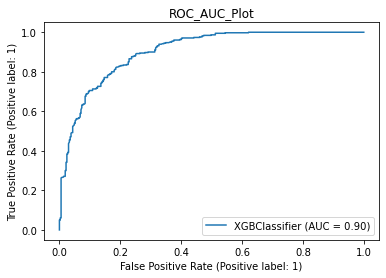

              precision    recall  f1-score   support

           0       0.85      0.77      0.80       367
           1       0.79      0.87      0.83       380

    accuracy                           0.82       747
   macro avg       0.82      0.82      0.82       747
weighted avg       0.82      0.82      0.82       747



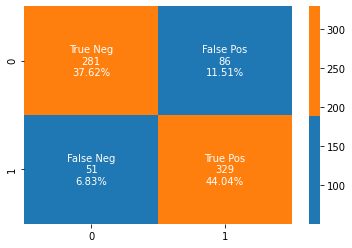

In [52]:
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)

model(classifier_xgb,x_train1,y_train1,x_test1,y_test1)
model_evaluation(classifier_xgb,x_test1,y_test1)

## Model for Data Leakage 

[21:59:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:59:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:59:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:59:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

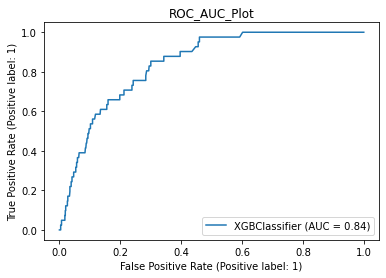

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       726
           1       0.00      0.00      0.00        41

    accuracy                           0.95       767
   macro avg       0.47      0.50      0.49       767
weighted avg       0.90      0.95      0.92       767



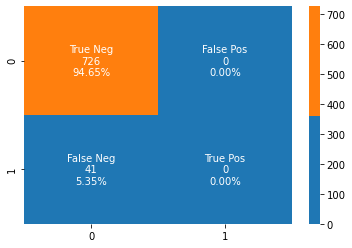

In [53]:
model(classifier_xgb,x_train2,y_train2,x_test2,y_test2)
model_evaluation(classifier_xgb,x_test2,y_test2)

This is another good dataset for understanding how to handle binary classification problems however, imbalance nature of the dataset makes it a tricky task to deal with.

It's EDA opportunities are immense as well. However, it's EDA insights did contradict with the domain knowledge.

In order to understand the significance of Data Leakage & it's effects, 2 models are created. You can easily spot the difference in statistical test values, feature selections and machine learning model performance.

F1 score of No Data Leakage Model suggests that it is more robust and can deal with the unknown data better than the Data Leakage Model.

In [54]:
# X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
# y = df['stroke']

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

In [55]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# RandomForestClassifier

In [56]:
n_estimators =[64,100,128,200]
max_features = [2,3,5,7]
bootstrap = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap}

In [57]:
rfc = RandomForestClassifier()

In [58]:
grid = GridSearchCV(rfc,param_grid)

grid.fit(x_train1,y_train1)

grid.best_params_

#{'bootstrap': True, 'max_features': 2, 'n_estimators': 100}

{'bootstrap': True, 'max_features': 5, 'n_estimators': 200}

In [59]:
# Let's use those params now

rfc =  RandomForestClassifier(**grid.best_params_)

rfc.fit(x_train1,y_train1)

rfc_tuned_pred = rfc.predict(x_test1)

In [60]:
print(classification_report(y_test1,rfc_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test1,rfc_tuned_pred))
print('F1 Score: ',f1_score(y_test1,rfc_tuned_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       367
           1       0.87      0.91      0.89       380

    accuracy                           0.88       747
   macro avg       0.89      0.88      0.88       747
weighted avg       0.89      0.88      0.88       747

Accuracy Score:  0.8848728246318608
F1 Score:  0.8894601542416453


Cross Validation Score :  95.74%
ROC_AUC Score :  89.10%


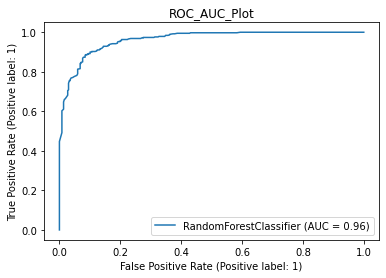

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       367
           1       0.87      0.93      0.90       380

    accuracy                           0.89       747
   macro avg       0.89      0.89      0.89       747
weighted avg       0.89      0.89      0.89       747



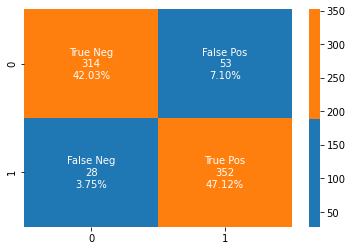

In [61]:
model1 =  RandomForestClassifier(**grid.best_params_)

model (model1,x_train1,y_train1,x_test1,y_test1)
model_evaluation(model1,x_test1,y_test1)

Cross Validation Score :  75.96%
ROC_AUC Score :  50.81%


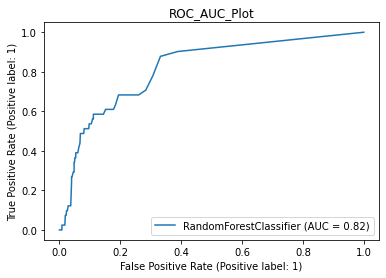

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       726
           1       0.14      0.02      0.04        41

    accuracy                           0.94       767
   macro avg       0.55      0.51      0.51       767
weighted avg       0.90      0.94      0.92       767



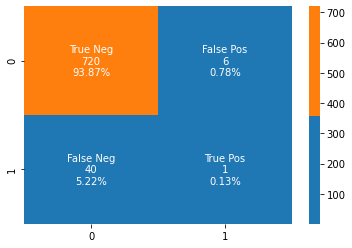

In [62]:
model2 = RandomForestClassifier(**grid.best_params_)
model(model2,x_train2,y_train2,x_test2,y_test2)
model_evaluation(model2,x_test2,y_test2)

# Logistic Regression

Logistic Regression had the highest f1 score above, so perhaps we can tune that for better results.

In [63]:
penalty = ['l1','l2']
C = [0.001, 0.01, 0.1, 1, 10, 100] 

log_param_grid = {'penalty': penalty, 
                  'C': C}
logreg = LogisticRegression()
grid = GridSearchCV(logreg,log_param_grid)

grid.fit(x_train1,y_train1)

grid.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [64]:
# Let's use those params now

logreg_pipeline = LogisticRegression(**grid.best_params_)

logreg_pipeline.fit(x_train1,y_train1)

#logreg.fit(X_train_resh,y_train_resh)

logreg_tuned_pred   = logreg_pipeline.predict(x_test1)

In [65]:
print(classification_report(y_test1,logreg_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test1,logreg_tuned_pred))
print('F1 Score: ',f1_score(y_test1,logreg_tuned_pred))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       367
           1       0.75      0.80      0.77       380

    accuracy                           0.76       747
   macro avg       0.76      0.76      0.76       747
weighted avg       0.76      0.76      0.76       747

Accuracy Score:  0.7617135207496654
F1 Score:  0.7729591836734695


Cross Validation Score :  87.14%
ROC_AUC Score :  76.11%


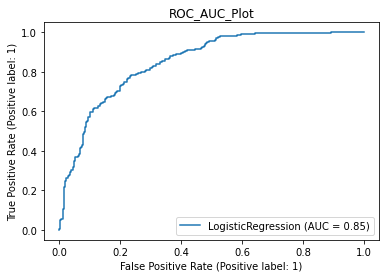

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       367
           1       0.75      0.80      0.77       380

    accuracy                           0.76       747
   macro avg       0.76      0.76      0.76       747
weighted avg       0.76      0.76      0.76       747



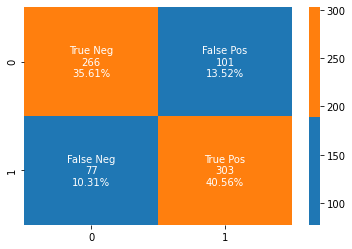

In [66]:
model1 = LogisticRegression(**grid.best_params_)
model(model1,x_train1,y_train1,x_test1,y_test1)
model_evaluation(model1,x_test1,y_test1)

Cross Validation Score :  83.19%
ROC_AUC Score :  50.00%


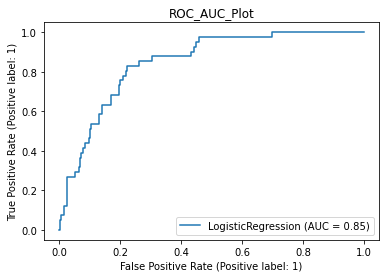

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       726
           1       0.00      0.00      0.00        41

    accuracy                           0.95       767
   macro avg       0.47      0.50      0.49       767
weighted avg       0.90      0.95      0.92       767



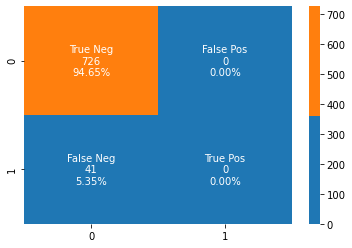

In [67]:
model2 = LogisticRegression(**grid.best_params_)
model(model2,x_train2,y_train2,x_test2,y_test2)
model_evaluation(model2,x_test2,y_test2)

So the hyper-parameter tuning has helped the Logisitc Regression model. It's recall score is much better than Random Forest's - even if the overall acuracy is down.

However, we can 

# Maniupulate the threshold 

that our model uses to classify stroke vs no-stroke. Let's try that...

In [68]:
#source code: https://www.kaggle.com/prashant111/extensive-analysis-eda-fe-modelling
# modified

from sklearn.preprocessing import binarize

for i in range(1,6):
    
    cm1=0
    y_pred1 = logreg_pipeline.predict_proba(x_test1)[:,1]
    y_pred1 = y_pred1.reshape(-1,1)
    y_pred2 = binarize(y_pred1, i/10)
    y_pred2 = np.where(y_pred2 == 1, 1, 0)
    cm1 = confusion_matrix(y_test1, y_pred2)
        
    print ('With',i/10,'threshold the Confusion Matrix is ','\n\n',cm1,'\n\n',
            'with',cm1[0,0]+cm1[1,1],'correct predictions, ', '\n\n', 
           
            cm1[0,1],'Type I errors( False Positives), ','\n\n',
           
            cm1[1,0],'Type II errors( False Negatives), ','\n\n',
           
           'Accuracy score: ', (accuracy_score(y_test1, y_pred2)), '\n\n',
           'F1 score: ', (f1_score(y_test1, y_pred2)), '\n\n',
           'Sensitivity: ',cm1[1,1]/(float(cm1[1,1]+cm1[1,0])), '\n\n',
           
           'Specificity: ',cm1[0,0]/(float(cm1[0,0]+cm1[0,1])),'\n\n',
          
            '====================================================', '\n\n')

With 0.1 threshold the Confusion Matrix is  

 [[ 74 293]
 [  1 379]] 

 with 453 correct predictions,  

 293 Type I errors( False Positives),  

 1 Type II errors( False Negatives),  

 Accuracy score:  0.606425702811245 

 F1 score:  0.7205323193916349 

 Sensitivity:  0.9973684210526316 

 Specificity:  0.2016348773841962 



With 0.2 threshold the Confusion Matrix is  

 [[146 221]
 [  3 377]] 

 with 523 correct predictions,  

 221 Type I errors( False Positives),  

 3 Type II errors( False Negatives),  

 Accuracy score:  0.7001338688085676 

 F1 score:  0.7709611451942741 

 Sensitivity:  0.9921052631578947 

 Specificity:  0.3978201634877384 



With 0.3 threshold the Confusion Matrix is  

 [[190 177]
 [ 23 357]] 

 with 547 correct predictions,  

 177 Type I errors( False Positives),  

 23 Type II errors( False Negatives),  

 Accuracy score:  0.7322623828647925 

 F1 score:  0.7811816192560175 

 Sensitivity:  0.9394736842105263 

 Specificity:  0.5177111716621253 



W

One can see how, by manipulating the threshold, we can catch more strokes. 

However, one needs to be careful with this approach. We could just change the threshold such that every patient is predicted to have a stroke so as not to miss any - but this helps no one.

The art is in finding the balance between 'hits' and 'misses'. 

F1 score is a decent starting point for this as it is the weighted average of several metrics.

Here's a chart showing what I mean

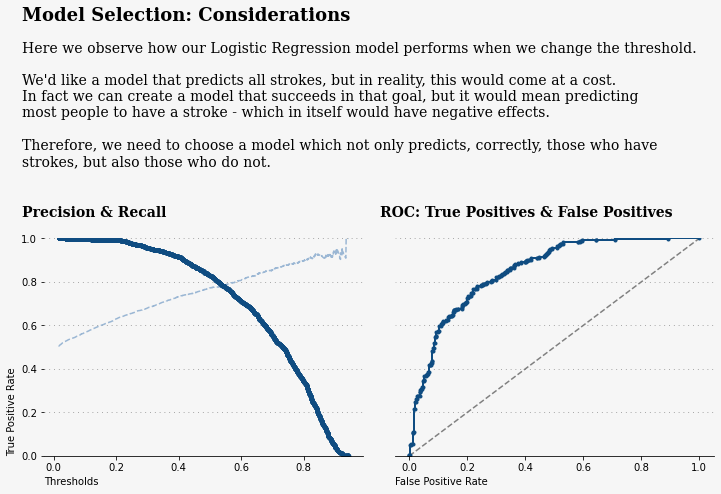

In [69]:
# source code: https://www.kaggle.com/ilyapozdnyakov/rain-in-australia-precision-recall-curves-viz
# heeavily modified plotting

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

ns_probs = [0 for _ in range(len(y_test1))]
lr_probs = logreg_pipeline.predict_proba(x_test1)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test1, ns_probs)
lr_auc = roc_auc_score(y_test1, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test1, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test1, lr_probs)



y_scores = logreg_pipeline.predict_proba(x_train1)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_train1, y_scores)



# Plots

fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1,2, wspace=0.1,hspace=0)
ax = gs.subplots()

background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color) # figure background color
ax[0].set_facecolor(background_color) 
ax[1].set_facecolor(background_color)

ax[0].grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax[1].grid(color='gray', linestyle=':', axis='y',  dashes=(1,5))



y_scores = logreg_pipeline.predict_proba(x_train1)[:,1]


precisions, recalls, thresholds = precision_recall_curve(y_train1, y_scores)

ax[0].plot(thresholds, precisions[:-1], 'b--', label='Precision',color='#9bb7d4')
ax[0].plot(thresholds, recalls[:-1], '.', linewidth=1,label='Recall',color='#0f4c81')
ax[0].set_ylabel('True Positive Rate',loc='bottom')
ax[0].set_xlabel('Thresholds',loc='left')
#plt.legend(loc='center left')
ax[0].set_ylim([0,1])


# plot the roc curve for the model
ax[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifer',color='gray')
ax[1].plot(lr_fpr, lr_tpr, marker='.', linewidth=2,color='#0f4c81')
ax[1].set_xlabel('False Positive Rate',loc='left')
ax[1].set_ylabel('')
ax[1].set_ylim([0,1])

for s in ["top","right","left"]:
    ax[0].spines[s].set_visible(False)
    ax[1].spines[s].set_visible(False)
    
    
ax[0].text(-0.1,2,'Model Selection: Considerations',fontsize=18,fontfamily='serif',fontweight='bold')
ax[0].text(-0.1,1.26,
'''
Here we observe how our Logistic Regression model performs when we change the threshold.

We'd like a model that predicts all strokes, but in reality, this would come at a cost.
In fact we can create a model that succeeds in that goal, but it would mean predicting
most people to have a stroke - which in itself would have negative effects.

Therefore, we need to choose a model which not only predicts, correctly, those who have
strokes, but also those who do not.
''',fontsize=14,fontfamily='serif')


ax[0].text(-0.1,1.1,'Precision & Recall',fontsize=14,fontfamily='serif',fontweight='bold')
ax[1].text(-0.1,1.1,'ROC: True Positives & False Positives',fontsize=14,fontfamily='serif',fontweight='bold')

ax[1].tick_params(axis='y', colors=background_color)

plt.show()

# SVM

In [70]:
# defining parameter range 
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000],  
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
             'kernel': ['rbf']} 

svm = SVC(random_state=42)

grid = GridSearchCV(svm,svm_param_grid)

grid.fit(x_train1,y_train1)

grid.best_params_

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}

In [71]:
# Let's use those params now

svm_pipeline = SVC(**grid.best_params_)

svm_pipeline.fit(x_train1,y_train1)

svm_tuned_pred   = svm_pipeline.predict(x_test1)

In [72]:
print(classification_report(y_test1,svm_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test1,svm_tuned_pred))
print('F1 Score: ',f1_score(y_test1,svm_tuned_pred))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       367
           1       0.78      0.86      0.82       380

    accuracy                           0.81       747
   macro avg       0.81      0.81      0.81       747
weighted avg       0.81      0.81      0.81       747

Accuracy Score:  0.8072289156626506
F1 Score:  0.8200000000000001


Cross Validation Score :  88.29%
ROC_AUC Score :  80.62%


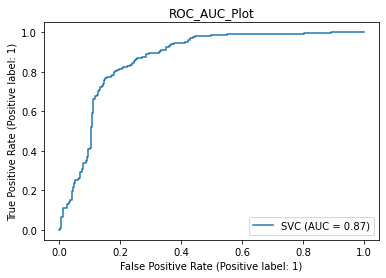

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       367
           1       0.78      0.86      0.82       380

    accuracy                           0.81       747
   macro avg       0.81      0.81      0.81       747
weighted avg       0.81      0.81      0.81       747



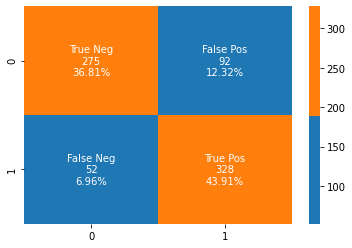

In [73]:
model1 = SVC(**grid.best_params_)
model(model1,x_train1,y_train1,x_test1,y_test1)
model_evaluation(model1,x_test1,y_test1)

Cross Validation Score :  70.30%
ROC_AUC Score :  50.00%


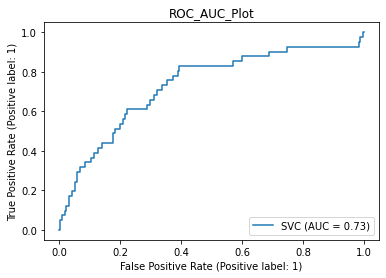

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       726
           1       0.00      0.00      0.00        41

    accuracy                           0.95       767
   macro avg       0.47      0.50      0.49       767
weighted avg       0.90      0.95      0.92       767



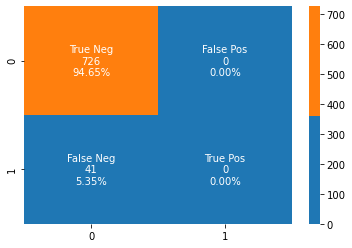

In [74]:
model2 = SVC(**grid.best_params_)
model(model2,x_train2,y_train2,x_test2,y_test2)
model_evaluation(model2,x_test2,y_test2)

In [75]:
feature_names = x_train.columns

def rf_feat_importance(model, feature_names):
    return pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

# ✅ Use df2 columns as feature names
fi = rf_feat_importance(rfc, x_train.columns)
fi[:10].style.background_gradient(cmap='viridis')

,Feature,Importance
1,age,0.500103
5,avg_glucose_level,0.340201
3,work_type,0.068464
4,Residence_type,0.033224
0,gender,0.033205
2,ever_married,0.024803


# SHAP

SHAP Values (SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 

It interprets the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value (e.g. zero)


In this case I will use it for the Random Forest Model. It can be used for any type of model but it is by far the quickest with tree based models.

It is possible to change the colour values in SHAP plots too


In [76]:
# great resource: https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
import shap  

explainer = shap.TreeExplainer(rfc)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(x_train)

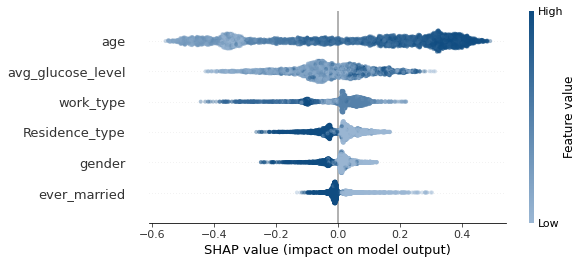

In [77]:
import matplotlib
# custom colour plot
colors = ["#9bb7d4", "#0f4c81"]           
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
shap.summary_plot(shap_values[1], x_train,cmap=cmap,alpha=0.4)

## SHAP explained

The plot above shows the effext of each data point on our predictions. 

For example, for age, the top left point reduced the prediction by 0.6.

The color shows whether that feature was high or low for that row of the dataset
Horizontal location shows whether the effect of that value caused a higher or lower prediction.


We can also see how our Random Forest Model is heavily skewed in favour of predicting no-strokes.

## There's more? SHAP dependence plots

We can also focus on how the impact of each variable changes, as the variable itself changes.

For instance, Age. When this variable increases, the SHAP value also increases - pushing the patient closer to  our 1 condition (stroke). 

This is also shown with colour -  pink/red representing those who suffered a stroke.

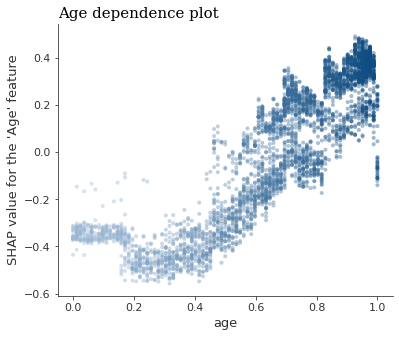

In [78]:
shap.dependence_plot('age', shap_values[1], x_train, interaction_index="age",cmap=cmap,alpha=0.4,show=False)
plt.title("Age dependence plot",loc='left',fontfamily='serif',fontsize=15)
plt.ylabel("SHAP value for the 'Age' feature")
plt.show()

The same plot, but with a more interesting varibale. 

Here we see a clear cutoff point for when strokes become far more common - after a BMI of around 30 or so.

Such is the power of SHAP visualization.

In [79]:
# shap.dependence_plot('bmi', shap_values[1], x_train, interaction_index="bmi",cmap=cmap,alpha=0.4,show=False)
# plt.title("BMI dependence plot",loc='left',fontfamily='serif',fontsize=15)
# plt.ylabel("SHAP value for the 'BMI' feature")
# plt.show()

#  Logistic Regression with LIME

When it comes to model interpretation, sometimes it is useful to unpack and focus on one example at a time.

The LIME package enables just that.

Lime stands for Local Interpretable Model-agnostic Explanations - here's an example:

In [80]:
import lime
import lime.lime_tabular

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=x_train.columns.values.tolist(),
                                                  class_names=['stroke'], verbose=True, mode='classification')

In [81]:
# Choose the jth instance and use it to predict the results for that selection
j = 1
exp = explainer.explain_instance(x_train.values[j], logreg_pipeline.predict_proba, num_features=5)


Intercept 0.36781573765012154
Prediction_local [0.29007549]
Right: 0.35685174635156813


In [82]:
# Show the predictions
exp.show_in_notebook(show_table=True)

#  ELI5 for feature explanation

ELI5 stands for Explain it like I am 5 - a quirky name!

Here we see the coefficient for each variable - in other words, what our Logistic model puts most value in.

In [83]:
import eli5


eli5.show_weights(logreg_pipeline, feature_names = x_train.columns.values.tolist())

Weight?,Feature
+4.863,age
+1.260,avg_glucose_level
-0.180,ever_married
-0.276,work_type
-0.288,gender
-0.393,Residence_type
-3.736,<BIAS>
